# Tutorial: mmini-batch technique on Stereo-seq (Mouse olfactory bulb)

This tutorial demonstrates how to train RGAST in batches on Stereo-seq data using RGAST to deal with large-scale data.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import RGAST

## read data

In [4]:
counts_file = os.path.join('/lustre/home/acct-clsyzs/clsyzs-gyq/ST-research/data/Mouse_Stereo/RNA_counts.tsv')
coor_file = os.path.join('/lustre/home/acct-clsyzs/clsyzs-gyq/ST-research/data/Mouse_Stereo/position.tsv')

In [5]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)

(27106, 19527) (19527, 3)


In [6]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [96]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()

In [97]:
coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()
sc.pp.calculate_qc_metrics(adata, inplace=True)

## preprocess

In [98]:
adata.raw = adata.copy()
sc.pp.filter_genes(adata, min_cells=20)
adata.layers['filtered'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True)
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=200)
sc.pp.normalize_total(adata, target_sum=1e4,layer='filtered')
sc.pp.log1p(adata,layer='filtered')

In [10]:
used_barcode = pd.read_csv(os.path.join('/lustre/home/acct-clsyzs/clsyzs-gyq/ST-research/data/Mouse_Stereo/used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

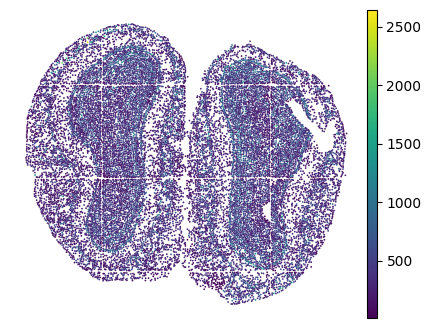

In [15]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

## Constructing the spatial network

In [11]:
RGAST.Cal_Spatial_Net(adata, rad_cutoff=50, model='Radius')
RGAST.Cal_Expression_Net(adata)

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.


## Running RGAST

In [12]:
train_RGAST = RGAST.Train_RGAST(adata, batch_data=True, num_batch_x_y=(2,2), spatial_net_arg={'rad_cutoff':50, 'model':'Radius'})

Size of Input:  (19109, 200)
------Calculating spatial graph...
The graph contains 31318 edges, 4309 cells.
7.2680 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 40448 edges, 5247 cells.
7.7088 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 37534 edges, 5246 cells.
7.1548 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 33534 edges, 4309 cells.
7.7823 neighbors per cell on average.


In [ ]:
train_RGAST.train_RGAST(early_stopping=False, save_path='.',n_clusters=7)
train_RGAST.train_with_dec() #optional

### you can also use the model parameter we have trained in the study

In [109]:
train_RGAST.load_model('../model_path/Mouse_Stereo.pth')
z, _ = train_RGAST.process()
adata.obsm['RGAST'] =  z.to('cpu').detach().numpy()

## clustering

In [110]:
sc.pp.neighbors(adata, use_rep='RGAST')
sc.tl.umap(adata)

In [ ]:
import RGAST.utils.res_search_fixed_clus as res_search_fixed_clus
_ = res_search_fixed_clus(adata, 7)

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

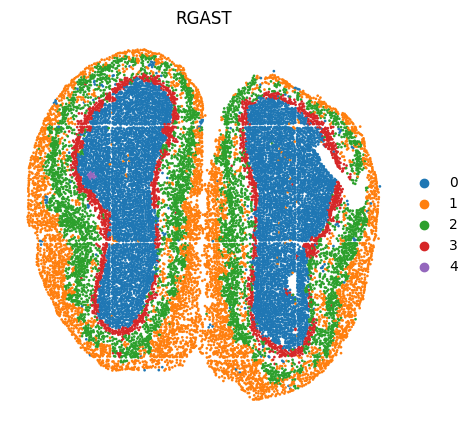

In [159]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="leiden",s=15, show=False, title='RGAST')
plt.axis('off')

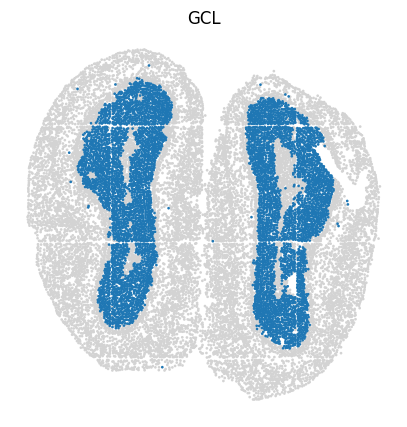

In [42]:
sc.pl.embedding(adata, basis="spatial", color="leiden",size=15, groups='0', show=False, title='GCL')
plt.axis('off')
plt.legend().remove()

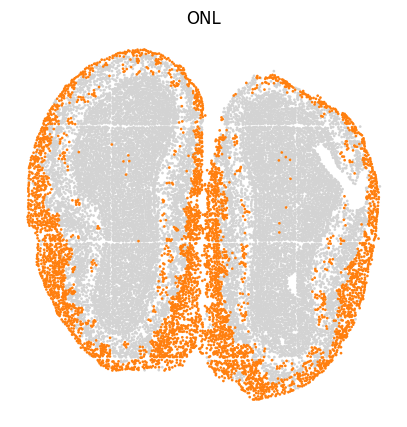

In [45]:
sc.pl.embedding(adata, basis="spatial", color="leiden",size=15, groups='1', show=False, title='ONL')
plt.axis('off')
plt.legend().remove()
plt.savefig(f'/lustre/home/acct-clsyzs/clsyzs-gyq/ST-research/analysis/clustering/output/Mouse_Stereo/RGAST/RGAST-1.pdf', bbox_inches='tight')

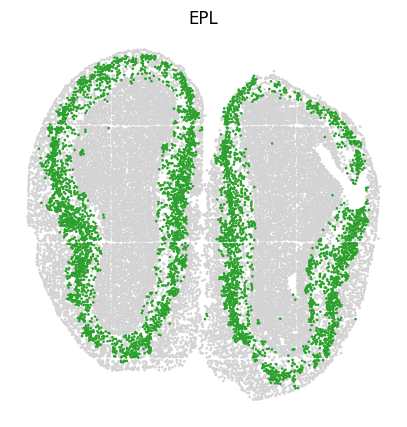

In [47]:
sc.pl.embedding(adata, basis="spatial", color="leiden",size=15, groups='2', show=False, title='EPL')
plt.axis('off')
plt.legend().remove()
plt.savefig(f'/lustre/home/acct-clsyzs/clsyzs-gyq/ST-research/analysis/clustering/output/Mouse_Stereo/RGAST/RGAST-2.pdf', bbox_inches='tight')

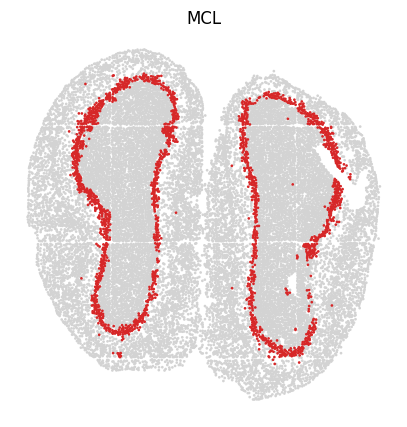

In [49]:
sc.pl.embedding(adata, basis="spatial", color="leiden",size=15, groups='3', show=False, title='MCL')
plt.axis('off')
plt.legend().remove()
plt.savefig(f'/lustre/home/acct-clsyzs/clsyzs-gyq/ST-research/analysis/clustering/output/Mouse_Stereo/RGAST/RGAST-3.pdf', bbox_inches='tight')

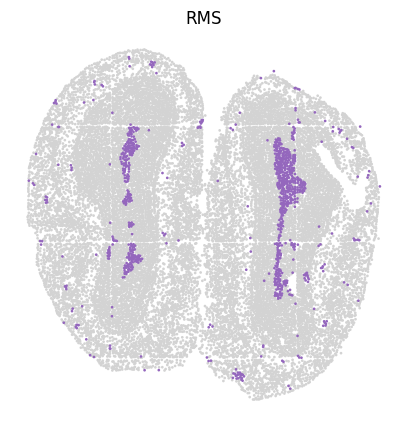

In [51]:
sc.pl.embedding(adata, basis="spatial", color="leiden",size=15, groups='4', show=False, title='RMS')
plt.axis('off')
plt.legend().remove()
plt.savefig(f'/lustre/home/acct-clsyzs/clsyzs-gyq/ST-research/analysis/clustering/output/Mouse_Stereo/RGAST/RGAST-4.pdf', bbox_inches='tight')

## marker genes' expression

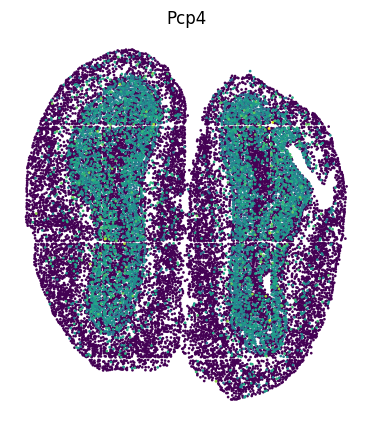

In [138]:
sc.pl.embedding(adata, basis="spatial", color='Pcp4',size=15, show=False, title='Pcp4', layer='filtered')
plt.axis('off')
plt.gcf().get_axes()[1].remove()p[;]

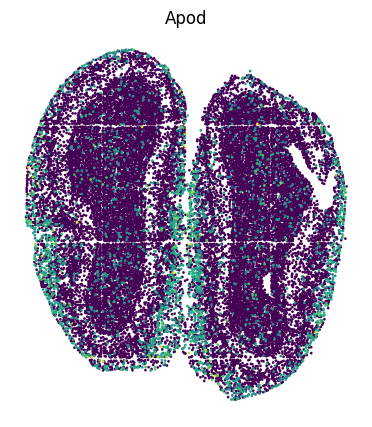

In [139]:
sc.pl.embedding(adata, basis="spatial", color='Cck',size=15, show=False, title='Apod', layer='filtered')
plt.axis('off')
plt.gcf().get_axes()[1].remove()

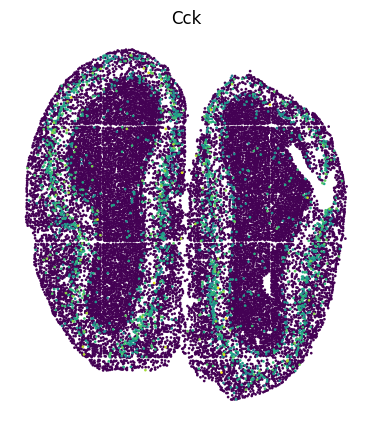

In [140]:
sc.pl.embedding(adata, basis="spatial", color='Cck',size=15, show=False, title='Cck', layer='filtered')
plt.axis('off')
plt.gcf().get_axes()[1].remove()

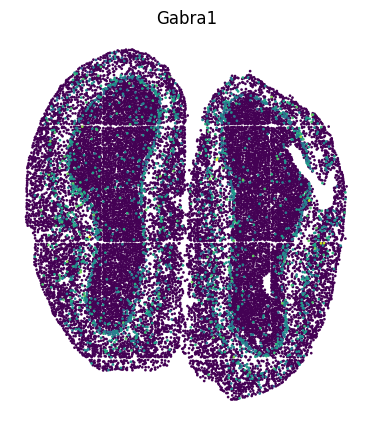

In [141]:
sc.pl.embedding(adata, basis="spatial", color='Gabra1',size=15, show=False, title='Gabra1', layer='filtered')
plt.axis('off')
plt.gcf().get_axes()[1].remove()

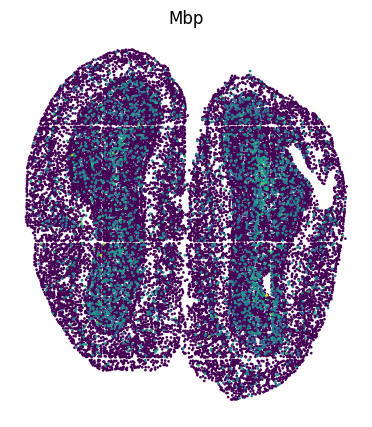

In [142]:
sc.pl.embedding(adata, basis="spatial", color='Mbp',size=15, show=False, title='Mbp', layer='filtered')
plt.axis('off')
plt.gcf().get_axes()[1].remove()